In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import tensorflow as tf
import strawberryfields as sf
from strawberryfields.ops import *
import pickle
import random as rd
import warnings
from datetime import datetime
import uncertainty_toolbox as uct
from itertools import product
from tqdm import tqdm

from dataloader import get_data, quartic_data
from plotting import plot_predictions, plot_training_results, plot_predictions_new, plot_eval_metrics
from baseline import train_mlp_baseline, predict_mlp_baseline, train_polynomial_baseline, predict_polynomial_baseline
from uq import selective_prediction, compute_eval_metrics
from model import train_memristor, predict_memristor, build_circuit
from utils import format_metrics, format_hyperparameters
from main import hyperparameter_optimization
from logger import log_experiment_id

tf.get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
rd.seed(42)

In [2]:
class Config:

    
    LOG_NAME = f"logs_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    LOG_FILE_NAME = f"reports/logs/experiment_{LOG_NAME}/log.txt"
    LOG_PATH = f"reports/logs/experiment_{LOG_NAME}/"
    
    # Hyperparameter Optimization
    HYPERPARAMETER_OPTIMIZATION = False
    HYPER_STEPS_RANGE = [10]
    HYPER_LEARNING_RATE_RANGE = [0.1]
    HYPER_MEMORY_DEPTH_RANGE = [4, 6]
    HYPER_CUTOFF_DIM_RANGE = [4, 6]

    # Model Comparison
    MODEL_COMPARISON = False
    COMP_N_SAMPLES = [2]
    COMP_MLP_ARCH = [[32], [64, 64], [128, 64, 64]]

    #TODO: Check for which params we have the same loss
    MLP_HIDDEN_LAYERS = [64, 64]
    MLP_EPOCHS = 100
    MLP_LEARNING_RATE = 0.01

    POLYNOMIAL_DEGREE = 3

    # Selective Prediction
    SELECTIVE_PREDICTION_THRESHOLD = 0.8

    # QNN Hyperparameters
    MEMORY_DEPTH = 2
    CUTOFF_DIM = 2
    TRAINING_STEPS = 10
    TRAINING_LEARNING_RATE = 0.2

    PREDICT_STOCHASTIC = True
    PREDICT_SAMPLES = 20
    PREDICT_VARIANCE = 0.1

    GET_DATA_N_DATA = 200
    GET_DATA_SIGMA_NOISE_1 = 0.1
    GET_DATA_DATAFUNCTION = quartic_data

    PARAM_ID = f"qnn_hp_s{TRAINING_STEPS}_lr{TRAINING_LEARNING_RATE}_md{MEMORY_DEPTH}_cd{CUTOFF_DIM}"


In [ ]:
# Create directory called experiment_CONFIG.LOG_NAME in reports/logs
os.makedirs(f"reports/logs/experiment_{Config.LOG_NAME}", exist_ok=False)

# Log experiment id
log_experiment_id(Config.LOG_FILE_NAME)

with open(Config.LOG_FILE_NAME, "a") as f:
    f.write("=" * 80 + "\n")
    f.write(f"Experiment_{Config.LOG_NAME}\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("=" * 80 + "\n\n")


X_train, y_train, X_test, y_test, _ = get_data(n_data=Config.GET_DATA_N_DATA, 
                                                sigma_noise_1=Config.GET_DATA_SIGMA_NOISE_1, 
                                                datafunction=Config.GET_DATA_DATAFUNCTION
                                                )

In [15]:
# Train model
res_mem, phase1, phase3, memristor_weight = train_memristor(X_train, 
                                                            y_train, 
                                                            memory_depth=Config.MEMORY_DEPTH, 
                                                            training_steps=Config.TRAINING_STEPS,
                                                            learning_rate=Config.TRAINING_LEARNING_RATE,
                                                            cutoff_dim=Config.CUTOFF_DIM,
                                                            log_filepath=Config.LOG_FILE_NAME,
                                                            log_path=Config.LOG_PATH,
                                                            param_id=Config.PARAM_ID
                                                            )

Training: 100%|██████████| 10/10 [00:36<00:00,  3.63s/step, loss=1.7422]


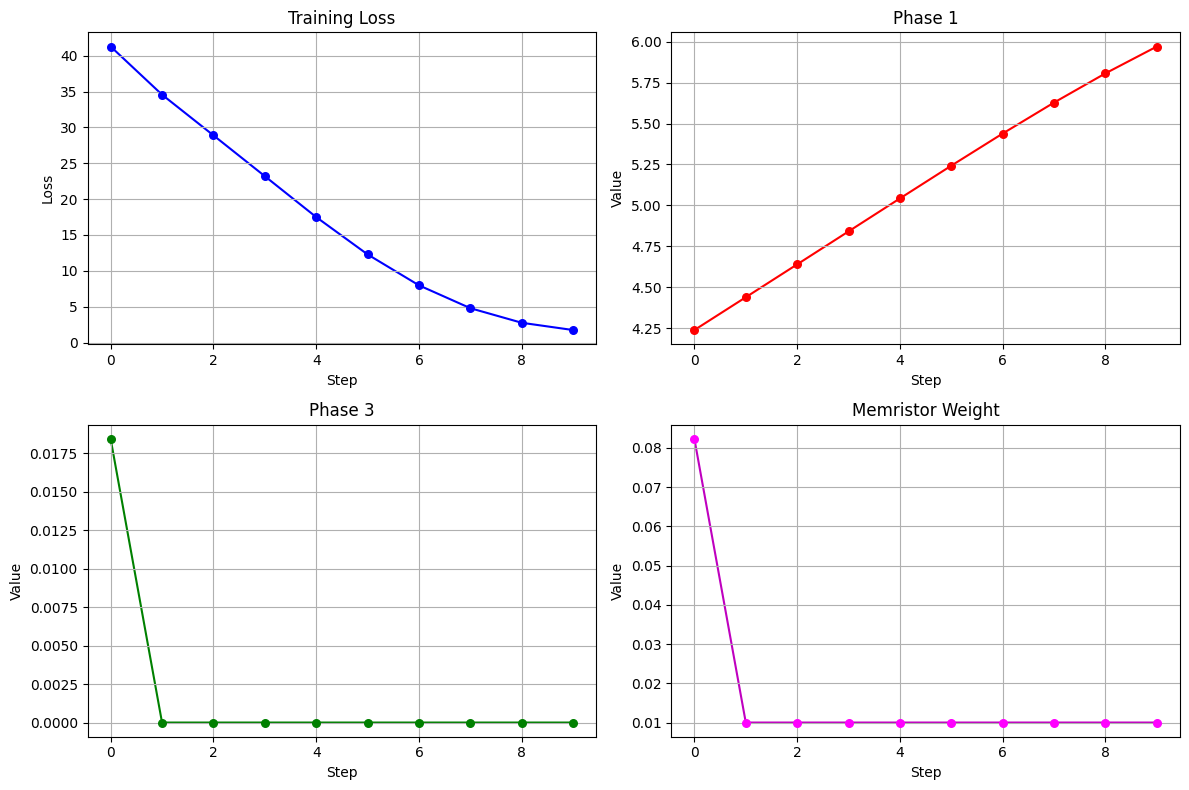

In [17]:
plot_training_results(res_mem)

In [18]:
# Predict model
predictions, targets, predictive_uncertainty = predict_memristor(X_test, 
                                                                y_test, 
                                                                memory_depth=Config.MEMORY_DEPTH, 
                                                                phase1=phase1, 
                                                                phase3=phase3, 
                                                                memristor_weight=memristor_weight,
                                                                stochastic=Config.PREDICT_STOCHASTIC, 
                                                                var=Config.PREDICT_VARIANCE, 
                                                                samples=Config.PREDICT_SAMPLES,
                                                                cutoff_dim=Config.CUTOFF_DIM,
                                                                log_filepath=Config.LOG_FILE_NAME,
                                                                log_path=Config.LOG_PATH,
                                                                param_id=Config.PARAM_ID
                                                                )

Prediction Samples: 100%|██████████| 20/20 [03:01<00:00,  9.05s/sample]


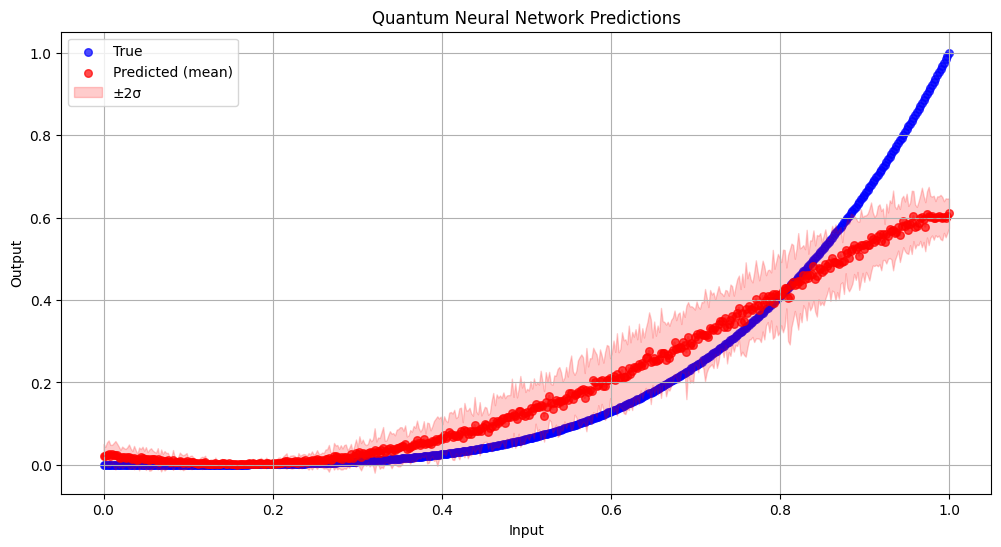

In [19]:
plot_predictions_new(X_test, y_test, predictions, predictive_uncertainty)

In [20]:
# Compute evaluation metrics for full predictions
full_metrics, full_metric_categories = compute_eval_metrics(predictions, 
                                                            targets, 
                                                            predictive_uncertainty,
                                                            Config.LOG_FILE_NAME,
                                                            Config.PARAM_ID,
                                                            name="Full Prediction"
                                                            )

In [27]:
sel_predictions, sel_targets, sel_uncertainty, remaining_fraction = selective_prediction(predictions, 
                                                                                                targets, 
                                                                                                predictive_uncertainty, 
                                                                                                threshold=Config.SELECTIVE_PREDICTION_THRESHOLD
                                                                                                )

In [4]:
# QNN Hyperparameters
MEMORY_DEPTH = 6
CUTOFF_DIM = 4
TRAINING_STEPS = 70
TRAINING_LEARNING_RATE = 0.1

PREDICT_STOCHASTIC = False
PREDICT_SAMPLES = 2
PREDICT_VARIANCE = 0.1

GET_DATA_N_DATA = 200
GET_DATA_SIGMA_NOISE_1 = 0.1
GET_DATA_DATAFUNCTION = quartic_data

# Selective Prediction
SELECTIVE_PREDICTION_THRESHOLD = 0.8

PARAM_ID = f"qnn_stoch{PREDICT_STOCHASTIC}_psamples{PREDICT_SAMPLES}_pvar{PREDICT_VARIANCE}_ndata{GET_DATA_N_DATA}_snoise{GET_DATA_SIGMA_NOISE_1}_threshold{SELECTIVE_PREDICTION_THRESHOLD}"


with open(Config.LOG_FILE_NAME, "a") as f:
        f.write("=" * 80 + "\n")
        f.write(f"Experiment_{Config.LOG_NAME}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("=" * 80 + "\n\n")

res_mem, phase1, phase3, memristor_weight = train_memristor(X_train, 
                                                            y_train, 
                                                            memory_depth=MEMORY_DEPTH, 
                                                            training_steps=TRAINING_STEPS,
                                                            learning_rate=TRAINING_LEARNING_RATE,
                                                            cutoff_dim=CUTOFF_DIM,
                                                            log_filepath=Config.LOG_FILE_NAME,
                                                            log_path=Config.LOG_PATH,
                                                            param_id=PARAM_ID
                                                            )


Training: 100%|██████████| 70/70 [05:36<00:00,  4.81s/step, loss=0.1830] 


In [ ]:
# Deterministic 

PREDICT_STOCHASTIC = False
PREDICT_SAMPLES = 30
PREDICT_VARIANCE = 0.1

GET_DATA_N_DATA = 200
GET_DATA_SIGMA_NOISE_1 = 0.1
GET_DATA_DATAFUNCTION = quartic_data

# Selective Prediction
SELECTIVE_PREDICTION_THRESHOLD = 0.8

PARAM_ID = f"qnn_stoch{PREDICT_STOCHASTIC}_psamples{PREDICT_SAMPLES}_pvar{PREDICT_VARIANCE}_ndata{GET_DATA_N_DATA}_snoise{GET_DATA_SIGMA_NOISE_1}_threshold{SELECTIVE_PREDICTION_THRESHOLD}"

with open(Config.LOG_FILE_NAME, "a") as f:
        f.write("=" * 80 + "\n")
        f.write(f"Experiment_{PARAM_ID}\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write("=" * 80 + "\n\n")

# Save training results
# with open(f"{Config.LOG_FILE_NAME}.pkl", "wb") as file:
#     pickle.dump(res_mem, file)

# Predict using the trained model
predictions, targets, predictive_uncertainty = predict_memristor(X_test, 
                                                                y_test, 
                                                                memory_depth=MEMORY_DEPTH, 
                                                                phase1=phase1, 
                                                                phase3=phase3, 
                                                                memristor_weight=memristor_weight,
                                                                stochastic=PREDICT_STOCHASTIC, 
                                                                var=PREDICT_VARIANCE, 
                                                                samples=PREDICT_SAMPLES,
                                                                cutoff_dim=CUTOFF_DIM,
                                                                log_filepath=Config.LOG_FILE_NAME,
                                                                log_path=Config.LOG_PATH,
                                                                param_id=PARAM_ID
                                                                )

# Ensure predictions and X_test have the same length
assert len(predictions) == len(X_test), "Predictions and X_test must have the same length"

# Convert predictions, targets, and predictive_uncertainty to NumPy arrays
predictions = np.array(predictions)
targets = np.array(targets)
predictive_uncertainty = np.array(predictive_uncertainty)

# Compute evaluation metrics for full predictions
full_metrics, full_metric_categories = compute_eval_metrics(predictions, 
                                                            targets, 
                                                            predictive_uncertainty,
                                                            Config.LOG_FILE_NAME,
                                                            PARAM_ID,
                                                            name="Full Prediction"
                                                            )

if PREDICT_STOCHASTIC:
    # Apply selective prediction
    sel_predictions, sel_targets, sel_uncertainty, remaining_fraction = selective_prediction(predictions, 
                                                                                            targets, 
                                                                                            predictive_uncertainty, 
                                                                                            threshold=Config.SELECTIVE_PREDICTION_THRESHOLD
                                                                                            )
    

    # Compute evaluation metrics for selective predictions
    sel_metrics, sel_metric_categories = compute_eval_metrics(sel_predictions, 
                                                            sel_targets, 
                                                            sel_uncertainty,
                                                            Config.LOG_FILE_NAME,
                                                            PARAM_ID,
                                                            name="Selective Prediction"
                                                            )

    # Save results to log file
    with open(Config.LOG_FILE_NAME, "a") as f:
        f.write(f"Selective Prediction Fraction: {remaining_fraction}\n")
        f.write("\n\n")

    # Plotting the results
    plot_predictions(
        X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy(),
        predictions, pred_std=predictive_uncertainty, epistemic=predictive_uncertainty,
        aleatoric=None, title="Memristor Model Predictions vs Targets", save_path=Config.LOG_PATH+f"prediction_uncertainty_{PARAM_ID}.png"
    )



Prediction Samples: 100%|██████████| 30/30 [05:31<00:00, 11.06s/sample]


 (1/n) Calculating accuracy metrics


In [7]:
PREDICT_STOCHASTIC = True
PREDICT_SAMPLES = [30, 50, 100]
PREDICT_VARIANCE = 0.1

GET_DATA_N_DATA = 200
GET_DATA_SIGMA_NOISE_1 = 0.1
GET_DATA_DATAFUNCTION = quartic_data

# Selective Prediction
SELECTIVE_PREDICTION_THRESHOLD = 0.8

sample_storage = []

for samples in PREDICT_SAMPLES:

    PARAM_ID = f"qnnv2_stoch{PREDICT_STOCHASTIC}_psamples{samples}_pvar{PREDICT_VARIANCE}_ndata{GET_DATA_N_DATA}_snoise{GET_DATA_SIGMA_NOISE_1}_threshold{SELECTIVE_PREDICTION_THRESHOLD}"

    with open(Config.LOG_FILE_NAME, "a") as f:
            f.write("=" * 80 + "\n")
            f.write(f"Experiment_{PARAM_ID}\n")
            f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")

    # Save training results
    # with open(f"{Config.LOG_FILE_NAME}.pkl", "wb") as file:
    #     pickle.dump(res_mem, file)

    # Predict using the trained model
    predictions, targets, predictive_uncertainty = predict_memristor(X_test, 
                                                                    y_test, 
                                                                    memory_depth=MEMORY_DEPTH, 
                                                                    phase1=phase1, 
                                                                    phase3=phase3, 
                                                                    memristor_weight=memristor_weight,
                                                                    stochastic=PREDICT_STOCHASTIC, 
                                                                    var=PREDICT_VARIANCE, 
                                                                    samples=samples,
                                                                    cutoff_dim=CUTOFF_DIM,
                                                                    log_filepath=Config.LOG_FILE_NAME,
                                                                    log_path=Config.LOG_PATH,
                                                                    param_id=PARAM_ID
                                                                    )
    sample_storage.append((predictions, targets, predictive_uncertainty))
    # Ensure predictions and X_test have the same length
    assert len(predictions) == len(X_test), "Predictions and X_test must have the same length"

    # Convert predictions, targets, and predictive_uncertainty to NumPy arrays
    predictions = np.array(predictions)
    targets = np.array(targets)
    predictive_uncertainty = np.array(predictive_uncertainty)

    # Compute evaluation metrics for full predictions
    full_metrics, full_metric_categories = compute_eval_metrics(predictions, 
                                                                targets, 
                                                                predictive_uncertainty,
                                                                Config.LOG_FILE_NAME,
                                                                PARAM_ID,
                                                                name="Full Prediction"
                                                                )

    if PREDICT_STOCHASTIC:
        # Apply selective prediction
        sel_predictions, sel_targets, sel_uncertainty, remaining_fraction = selective_prediction(predictions, 
                                                                                                targets, 
                                                                                                predictive_uncertainty, 
                                                                                                threshold=Config.SELECTIVE_PREDICTION_THRESHOLD
                                                                                                )
        

        # Compute evaluation metrics for selective predictions
        sel_metrics, sel_metric_categories = compute_eval_metrics(sel_predictions, 
                                                                sel_targets, 
                                                                sel_uncertainty,
                                                                Config.LOG_FILE_NAME,
                                                                PARAM_ID,
                                                                name="Selective Prediction"
                                                                )

        # Save results to log file
        with open(Config.LOG_FILE_NAME, "a") as f:
            f.write(f"Selective Prediction Fraction: {remaining_fraction}\n")
            f.write("\n\n")

        # Plotting the results
        plot_predictions(
            X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy(),
            predictions, pred_std=predictive_uncertainty, epistemic=predictive_uncertainty,
            aleatoric=None, title="Memristor Model Predictions vs Targets", save_path=Config.LOG_PATH+f"prediction_uncertainty_{PARAM_ID}.png"
        )

Prediction Samples: 100%|██████████| 100/100 [18:02<00:00, 10.82s/sample]


In [ ]:
# Different selective prediction thresholds

PREDICT_STOCHASTIC = True
# PREDICT_SAMPLES = [30, 50, 100]
PREDICT_VARIANCE = 0.1

GET_DATA_N_DATA = 200
GET_DATA_SIGMA_NOISE_1 = 0.1
GET_DATA_DATAFUNCTION = quartic_data

# Selective Prediction
SELECTIVE_PREDICTION_THRESHOLD = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

rmse_values_dic = {str(PREDICT_SAMPLES[i]) : [] for i in range(len(PREDICT_SAMPLES))}

for index, samples in enumerate(sample_storage):
    for threshold in SELECTIVE_PREDICTION_THRESHOLD:
        

        PARAM_ID = f"qnn_stoch{PREDICT_STOCHASTIC}_psamples{PREDICT_SAMPLES}_pvar{PREDICT_VARIANCE}_ndata{GET_DATA_N_DATA}_snoise{GET_DATA_SIGMA_NOISE_1}_threshold{threshold}"

        with open(Config.LOG_FILE_NAME, "a") as f:
                f.write("=" * 80 + "\n")
                f.write(f"Experiment_{PARAM_ID}\n")
                f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("=" * 80 + "\n\n")

        if PREDICT_STOCHASTIC:
            # Apply selective prediction
            sel_predictions, sel_targets, sel_uncertainty, remaining_fraction = selective_prediction(samples[0], 
                                                                                                    samples[1], 
                                                                                                    samples[2], 
                                                                                                    threshold=threshold
                                                                                                    )
            
            plot_predictions_new(X_test, y_test, predictions, predictive_uncertainty, Config.LOG_PATH+f"prediction_results_{PARAM_ID}.png")

            # Compute evaluation metrics for selective predictions
            sel_metrics, sel_metric_categories = compute_eval_metrics(sel_predictions, 
                                                                    sel_targets, 
                                                                    sel_uncertainty,
                                                                    Config.LOG_FILE_NAME,
                                                                    PARAM_ID,
                                                                    name="Selective Prediction"
                                                                    )
            
            rmse_values_dic[str(PREDICT_SAMPLES[index])].append(sel_metrics['accuracy']["rmse"])

            # Save results to log file
            with open(Config.LOG_FILE_NAME, "a") as f:
                f.write(f"Selective Prediction Fraction: {remaining_fraction}\n")
                f.write("\n\n")

            # Plotting the results
            plot_predictions(
                X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy(),
                predictions, pred_std=predictive_uncertainty, epistemic=predictive_uncertainty,
                aleatoric=None, title="Memristor Model Predictions vs Targets", save_path=Config.LOG_PATH+f"prediction_uncertainty_{PARAM_ID}.png"
            )



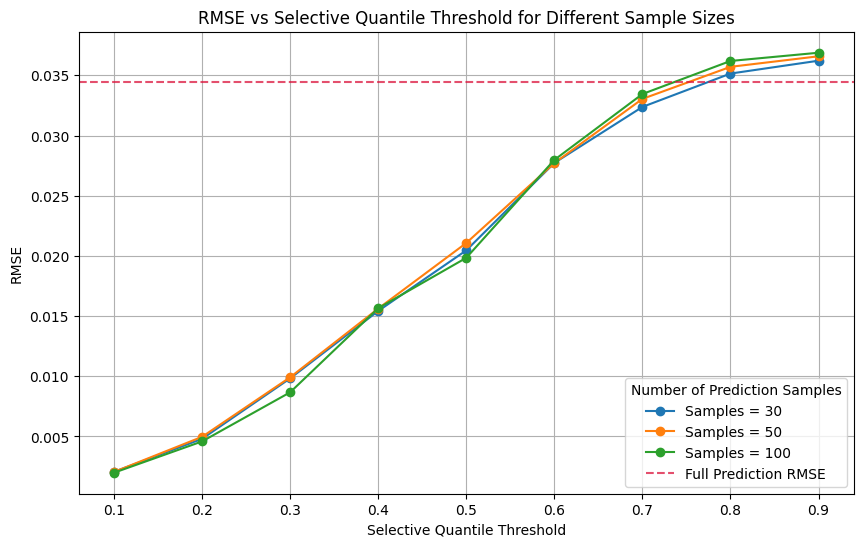

In [21]:
import matplotlib.pyplot as plt



def plot_rmse_vs_threshold(rmse_values_dic, save_path=None):
    # After storing RMSE values in rmse_values_dic, add the plotting code
    plt.figure(figsize=(10, 6))

    # Iterate over each sample size and its corresponding RMSE values
    for sample_size_str, rmse_values in rmse_values_dic.items():
        # Convert sample size back to integer or keep as string for labeling
        sample_size = int(sample_size_str)
        # Plot RMSE vs Threshold for this sample size
        plt.plot(SELECTIVE_PREDICTION_THRESHOLD, rmse_values, marker='o', label=f'Samples = {sample_size}')

    # Customize the plot
    plt.xlabel('Selective Quantile Threshold')
    plt.ylabel('RMSE')
    plt.axhline(0.03445702371, color='crimson', alpha=0.75, linestyle='--', label='Full Prediction RMSE')
    plt.title('RMSE vs Selective Quantile Threshold for Different Sample Sizes')
    plt.legend(title='Number of Prediction Samples')
    plt.grid(True)

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()


for n_samples, sample in enumerate(sample_storage):
    plot_predictions_new(X_test, y_test, sample[0], sample[2], Config.LOG_PATH+f"prediction_{PREDICT_SAMPLES[n_samples]}_{PARAM_ID}.png")

plot_rmse_vs_threshold(rmse_values_dic, Config.LOG_PATH+f"rmse_vs_threshold.png")